In [168]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [169]:
tickers = ['NOW','TSLA','ABBV','MA', 'OXY']
end_date = datetime(year=2021, month=12, day = 31)
#end_date = datetime.today()
start_date = end_date - timedelta(days = 2*365)


In [170]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [171]:
print(adj_close_df)

                   NOW        TSLA        ABBV          MA        OXY
Date                                                                 
2020-01-02  291.239990   28.684000   74.197624  296.263519  40.361671
2020-01-03  291.100006   29.534000   73.493347  293.373047  41.338017
2020-01-06  292.869995   30.102667   74.073334  294.154236  42.702991
2020-01-07  292.910004   31.270666   73.650772  293.158203  42.911530
2020-01-08  295.649994   32.809334   74.172760  298.330872  42.636639
...                ...         ...         ...         ...        ...
2021-12-23  648.570007  355.666656  121.959908  355.744965  28.273941
2021-12-27  663.280029  364.646667  123.169518  355.478607  29.048166
2021-12-28  654.000000  362.823334  123.151207  355.942352  28.891365
2021-12-29  654.580017  362.063324  124.040092  356.445465  28.675755
2021-12-30  654.539978  356.779999  124.562408  356.149475  28.391542

[504 rows x 5 columns]


In [172]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [173]:
log_returns = log_returns.dropna()

In [174]:
log_returns

,NOW,TSLA,ABBV,MA,OXY
Date,,,,,
2020-01-03,-0.000481,0.029203,-0.009537,-0.009804,0.023902
2020-01-06,0.006062,0.019072,0.007861,0.002659,0.032486
2020-01-07,0.000137,0.038067,-0.005721,-0.003392,0.004872
2020-01-08,0.009311,0.048033,0.007062,0.017491,-0.006427
2020-01-09,0.012304,-0.022189,0.007678,0.013025,0.008633
...,...,...,...,...,...
2021-12-23,0.007180,0.056020,0.007845,0.008634,-0.002423
2021-12-27,0.022427,0.024935,0.009869,-0.000749,0.027015
2021-12-28,-0.014090,-0.005013,-0.000149,0.001304,-0.005413


In [175]:
cov_matrix = log_returns.cov() * 252

In [176]:
cov_matrix

,NOW,TSLA,ABBV,MA,OXY
NOW,0.187530,0.138205,0.046917,0.092767,0.090169
TSLA,0.138205,0.551751,0.053019,0.109883,0.172001
ABBV,0.046917,0.053019,0.082085,0.059795,0.090873
MA,0.092767,0.109883,0.059795,0.159376,0.173915
OXY,0.090169,0.172001,0.090873,0.173915,0.876859


In [177]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [178]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [179]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
NOW: 0.0671
TSLA: 0.5000
ABBV: 0.4329
MA: 0.0000
OXY: 0.0000
Expected Annual Return: 0.7710
Expected Volatility: 0.4349
Sharpe Ratio: 1.7270


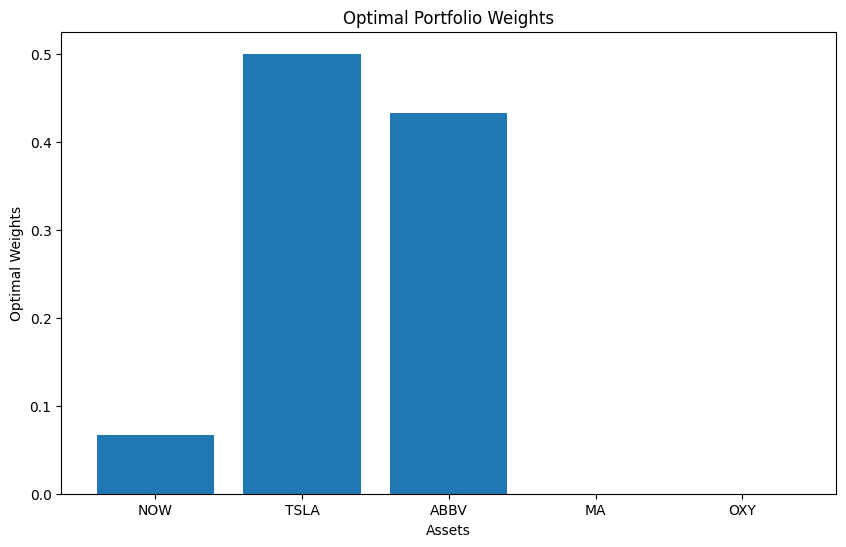

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()